# Data augmentation for object detection

In [1]:
from PIL import Image, ImageDraw #version 6.1.0
import PIL #version 1.2.0
import torch
import os
import xml.etree.ElementTree as ET
import torchvision.transforms.functional as F
import numpy as np
import random
from IPython.display import display

In [2]:
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 
              'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 
              'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v+1 for v, k in enumerate(voc_labels)}
#Inverse mapping
rev_label_map = {v: k for k, v in label_map.items()}
#Colormap for bounding box
CLASSES = 20
distinct_colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                   for i in range(CLASSES)]
label_color_map  = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [3]:
def parse_annot(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = list()
    labels = list()
    difficulties = list()
    
    for object in root.iter("object"):
        difficult = int(object.find("difficult").text == "1")
        label = object.find("name").text.lower().strip()
        if label not in label_map:
            print("{0} not in label map.".format(label))
            assert label in label_map
            
        bbox =  object.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)
        
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)
        
    return {"boxes": boxes, "labels": labels, "difficulties": difficulties}

def draw_PIL_image(image, boxes, labels):
    '''
        Draw PIL image
        image: A PIL image
        labels: A tensor of dimensions (#objects,)
        boxes: A tensor of dimensions (#objects, 4)
    '''
    if type(image) != PIL.Image.Image:
        image = F.to_pil_image(image)
    new_image = image.copy()
    labels = labels.tolist()
    draw = ImageDraw.Draw(new_image)
    boxes = boxes.tolist()
    for i in range(len(boxes)):
        draw.rectangle(xy= boxes[i], outline= label_color_map[rev_label_map[labels[i]]])
    
    display(new_image)

## Original Image

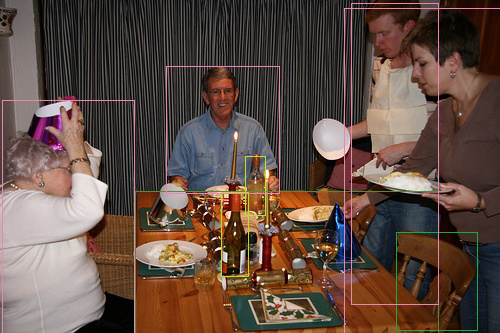

In [4]:
image = Image.open("./data/000144.jpg", mode= "r")
image = image.convert("RGB")
objects= parse_annot("./data/000144.xml")
boxes = torch.FloatTensor(objects['boxes'])
labels = torch.LongTensor(objects['labels']) 
difficulties = torch.ByteTensor(objects['difficulties'])
draw_PIL_image(image, boxes, labels)

### Adjust Contrast

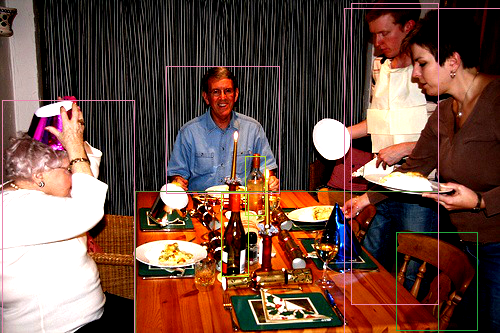

In [5]:
def Adjust_contrast(image):
    return F.adjust_contrast(image,2)
new_image = Adjust_contrast(image)
draw_PIL_image(new_image, boxes, labels)

### Adjust Brightness

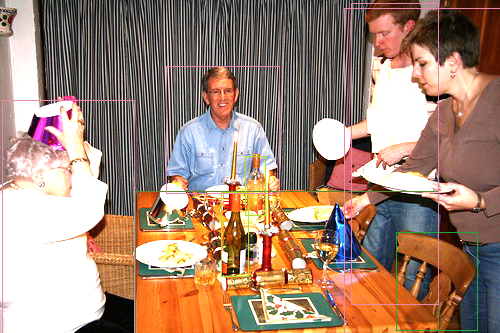

In [6]:
def Adjust_brightness(image):
    return F.adjust_brightness(image, 2)
new_image = Adjust_brightness(image)
draw_PIL_image(new_image, boxes, labels)

### Adjust saturation

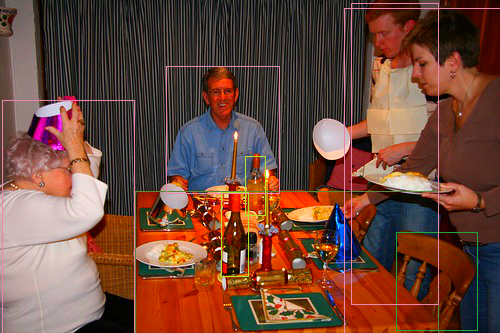

In [7]:
def Adjust_saturation(image):
    return F.adjust_saturation(image, 2)
new_image = Adjust_saturation(image)
draw_PIL_image(new_image, boxes, labels)

### Lighting Noise

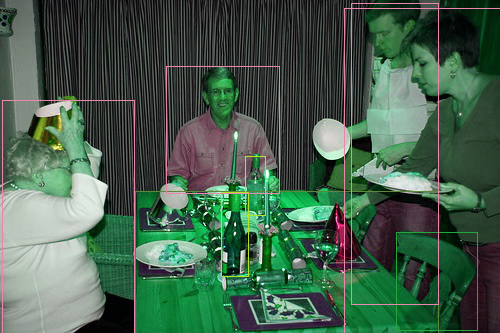

In [8]:
def lighting_noise(image):
    '''
        color channel swap in image
        image: A PIL image
    '''
    new_image = image
    perms = ((0, 1, 2), (0, 2, 1), (1, 0, 2), 
             (1, 2, 0), (2, 0, 1), (2, 1, 0))
    swap = perms[random.randint(0, len(perms)- 1)]
    new_image = F.to_tensor(new_image)
    new_image = new_image[swap, :, :]
    new_image = F.to_pil_image(new_image)
    return new_image

new_image = lighting_noise(image)
draw_PIL_image(new_image, boxes, labels)

### Flip

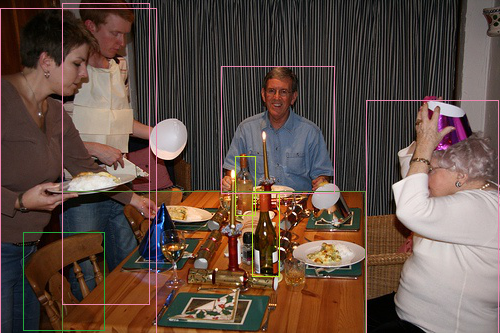

In [9]:
def flip(image, boxes):
    '''
        Flip image horizontally.
        image: a PIL image
        boxes: Bounding boxes, a tensor of dimensions (#objects, 4)
    '''
    new_image = F.hflip(image)
    
    #flip boxes 
    new_boxes = boxes.clone()
    new_boxes[:, 0] = image.width - boxes[:, 0]
    new_boxes[:, 2] = image.width - boxes[:, 2]
    new_boxes = new_boxes[:, [2, 1, 0, 3]]
    return new_image, new_boxes

new_image, new_boxes = flip(image, boxes)
draw_PIL_image(new_image, new_boxes, labels)

### Rotate

In [10]:
def rotate(image, boxes, angle):
    '''
        Rotate image and bounding box
        image: A Pil image (w, h)
        boxes: A tensors of dimensions (#objects, 4)
        
        Out: rotated image (w, h), rotated boxes
    '''
    new_image = image.copy()
    new_boxes = boxes.clone()
    
    #Rotate image, expand = True
    w = image.width
    h = image.height
    cx = w/2
    cy = h/2
    new_image = new_image.rotate(angle, expand= True)
    angle = np.radians(angle)
    alpha = np.cos(angle)
    beta = np.sin(angle)
    #Get affine matrix
    AffineMatrix = torch.tensor([[alpha, beta, (1-alpha)*cx - beta*cy],
                                 [-beta, alpha, beta*cx + (1-alpha)*cy]])
    
    #Rotation boxes
    box_width = (boxes[:,2] - boxes[:,0]).reshape(-1,1)
    box_height = (boxes[:,3] - boxes[:,1]).reshape(-1,1)
    
    #Get corners for boxes
    x1 = boxes[:,0].reshape(-1,1)
    y1 = boxes[:,1].reshape(-1,1)
    
    x2 = x1 + box_width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + box_height
    
    x4 = boxes[:,2].reshape(-1,1)
    y4 = boxes[:,3].reshape(-1,1)
    
    corners = torch.stack((x1,y1,x2,y2,x3,y3,x4,y4), dim= 1)
    corners.reshape(8, 8)    #Tensors of dimensions (#objects, 8)
    corners = corners.reshape(-1,2) #Tensors of dimension (4* #objects, 2)
    corners = torch.cat((corners, torch.ones(corners.shape[0], 1)), dim= 1) #(Tensors of dimension (4* #objects, 3))
    
    cos = np.abs(AffineMatrix[0, 0])
    sin = np.abs(AffineMatrix[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    AffineMatrix[0, 2] += (nW / 2) - cx
    AffineMatrix[1, 2] += (nH / 2) - cy
    
    #Apply affine transform
    rotate_corners = torch.mm(AffineMatrix, corners.t()).t()
    rotate_corners = rotate_corners.reshape(-1,8)
    
    x_corners = rotate_corners[:,[0,2,4,6]]
    y_corners = rotate_corners[:,[1,3,5,7]]
    
    #Get (x_min, y_min, x_max, y_max)
    x_min, _ = torch.min(x_corners, dim= 1)
    x_min = x_min.reshape(-1, 1)
    y_min, _ = torch.min(y_corners, dim= 1)
    y_min = y_min.reshape(-1, 1)
    x_max, _ = torch.max(x_corners, dim= 1)
    x_max = x_max.reshape(-1, 1)
    y_max, _ = torch.max(y_corners, dim= 1)
    y_max = y_max.reshape(-1, 1)
    
    new_boxes = torch.cat((x_min, y_min, x_max, y_max), dim= 1)
    
    scale_x = new_image.width / w
    scale_y = new_image.height / h
    
    #Resize new image to (w, h)
    new_image = new_image.resize((500, 333))
    
    #Resize boxes
    new_boxes /= torch.Tensor([scale_x, scale_y, scale_x, scale_y])
    new_boxes[:, 0] = torch.clamp(new_boxes[:, 0], 0, w)
    new_boxes[:, 1] = torch.clamp(new_boxes[:, 1], 0, h)
    new_boxes[:, 2] = torch.clamp(new_boxes[:, 2], 0, w)
    new_boxes[:, 3] = torch.clamp(new_boxes[:, 3], 0, h)
    return new_image, new_boxes

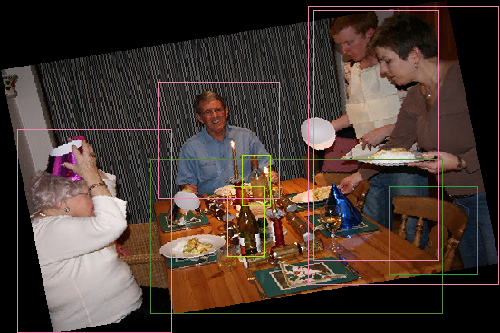

In [11]:
new_image, new_boxes= rotate(image, boxes, 10)
draw_PIL_image(new_image, new_boxes, labels)

### Random crop

In [12]:
def intersect(boxes1, boxes2):
    '''
        Find intersection of every box combination between two sets of box
        boxes1: bounding boxes 1, a tensor of dimensions (n1, 4)
        boxes2: bounding boxes 2, a tensor of dimensions (n2, 4)
        
        Out: Intersection each of boxes1 with respect to each of boxes2, 
             a tensor of dimensions (n1, n2)
    '''
    n1 = boxes1.size(0)
    n2 = boxes2.size(0)
    max_xy =  torch.min(boxes1[:, 2:].unsqueeze(1).expand(n1, n2, 2),
                        boxes2[:, 2:].unsqueeze(0).expand(n1, n2, 2))
    
    min_xy = torch.max(boxes1[:, :2].unsqueeze(1).expand(n1, n2, 2),
                       boxes2[:, :2].unsqueeze(0).expand(n1, n2, 2))
    inter = torch.clamp(max_xy - min_xy , min=0)  # (n1, n2, 2)
    return inter[:, :, 0] * inter[:, :, 1]  #(n1, n2)
def find_IoU(boxes1, boxes2):
    '''
        Find IoU between every boxes set of boxes 
        boxes1: a tensor of dimensions (n1, 4) (left, top, right , bottom)
        boxes2: a tensor of dimensions (n2, 4)
        
        Out: IoU each of boxes1 with respect to each of boxes2, a tensor of 
             dimensions (n1, n2)
        
        Formula: 
        (box1 ∩ box2) / (box1 u box2) = (box1 ∩ box2) / (area(box1) + area(box2) - (box1 ∩ box2 ))
    '''
    inter = intersect(boxes1, boxes2)
    area_boxes1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])
    area_boxes2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])
    
    area_boxes1 = area_boxes1.unsqueeze(1).expand_as(inter) #(n1, n2)
    area_boxes2 = area_boxes2.unsqueeze(0).expand_as(inter)  #(n1, n2)
    union = (area_boxes1 + area_boxes2 - inter)
    return inter / union

In [13]:
def random_crop(image, boxes, labels, difficulties):
    '''
        image: A PIL image
        boxes: Bounding boxes, a tensor of dimensions (#objects, 4)
        labels: labels of object, a tensor of dimensions (#objects)
        difficulties: difficulties of detect object, a tensor of dimensions (#objects)
        
        Out: cropped image , new boxes, new labels, new difficulties
    '''
    if type(image) == PIL.Image.Image:
        image = F.to_tensor(image)
    original_h = image.size(1)
    original_w = image.size(2)
    
    while True:
        mode = random.choice([0.1, 0.3, 0.5, 0.9, None])
        
        if mode is None:
            return image, boxes, labels, difficulties
        
        new_image = image
        new_boxes = boxes
        new_difficulties = difficulties
        new_labels = labels
        for _ in range(50):
            # Crop dimensions: [0.3, 1] of original dimensions
            new_h = random.uniform(0.3*original_h, original_h)
            new_w = random.uniform(0.3*original_w, original_w)
            
            # Aspect ratio constraint b/t .5 & 2
            if new_h/new_w < 0.5 or new_h/new_w > 2:
                continue
            
            #Crop coordinate
            left = random.uniform(0, original_w - new_w)
            right = left + new_w
            top = random.uniform(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([int(left), int(top), int(right), int(bottom)])
            
            # Calculate IoU  between the crop and the bounding boxes
            overlap = find_IoU(crop.unsqueeze(0), boxes) #(1, #objects)
            overlap = overlap.squeeze(0)
            # If not a single bounding box has a IoU of greater than the minimum, try again
            if overlap.max().item() < mode:
                continue
            
            #Crop
            new_image = image[:, int(top):int(bottom), int(left):int(right)] #(3, new_h, new_w)
            
            #Center of bounding boxes
            center_bb = (boxes[:, :2] + boxes[:, 2:])/2.0
            
            #Find bounding box has been had center in crop
            center_in_crop = (center_bb[:, 0] >left) * (center_bb[:, 0] < right
                             ) *(center_bb[:, 1] > top) * (center_bb[:, 1] < bottom)    #( #objects)
            
            if not center_in_crop.any():
                continue
            
            #take matching bounding box
            new_boxes = boxes[center_in_crop, :]
            
            #take matching labels
            new_labels = labels[center_in_crop]
            
            #take matching difficulities
            new_difficulties = difficulties[center_in_crop]
            
            #Use the box left and top corner or the crop's
            new_boxes[:, :2] = torch.max(new_boxes[:, :2], crop[:2])
            
            #adjust to crop
            new_boxes[:, :2] -= crop[:2]
            
            new_boxes[:, 2:] = torch.min(new_boxes[:, 2:],crop[2:])
            
            #adjust to crop
            new_boxes[:, 2:] -= crop[:2]
            
            return F.to_pil_image(new_image), new_boxes, new_labels, new_difficulties

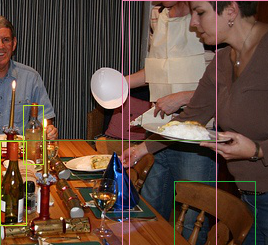

In [14]:
new_image,new_boxes, new_labels, new_difficulties = random_crop(image, boxes,labels, difficulties)
draw_PIL_image(new_image, new_boxes, new_labels)

### Zoom out (expand image)

In [15]:
def zoom_out(image, boxes):
    '''
        Zoom out image (max scale = 4)
        image: A PIL image
        boxes: bounding boxes, a tensor of dimensions (#objects, 4)
        
        Out: new_image, new_boxes
    '''
    if type(image) == PIL.Image.Image:
        image = F.to_tensor(image)
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale*original_h)
    new_w = int(scale*original_w)
    
    #Create an image with the filler
    filler = [0.485, 0.456, 0.406]
    filler = torch.FloatTensor(filler) #(3)
    new_image = torch.ones((3, new_h, new_w), dtype= torch.float) * filler.unsqueeze(1).unsqueeze(1)
    

    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    
    new_image[:, top:bottom, left:right] = image
    
    #Adjust bounding box
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(0)
    
    return new_image, new_boxes

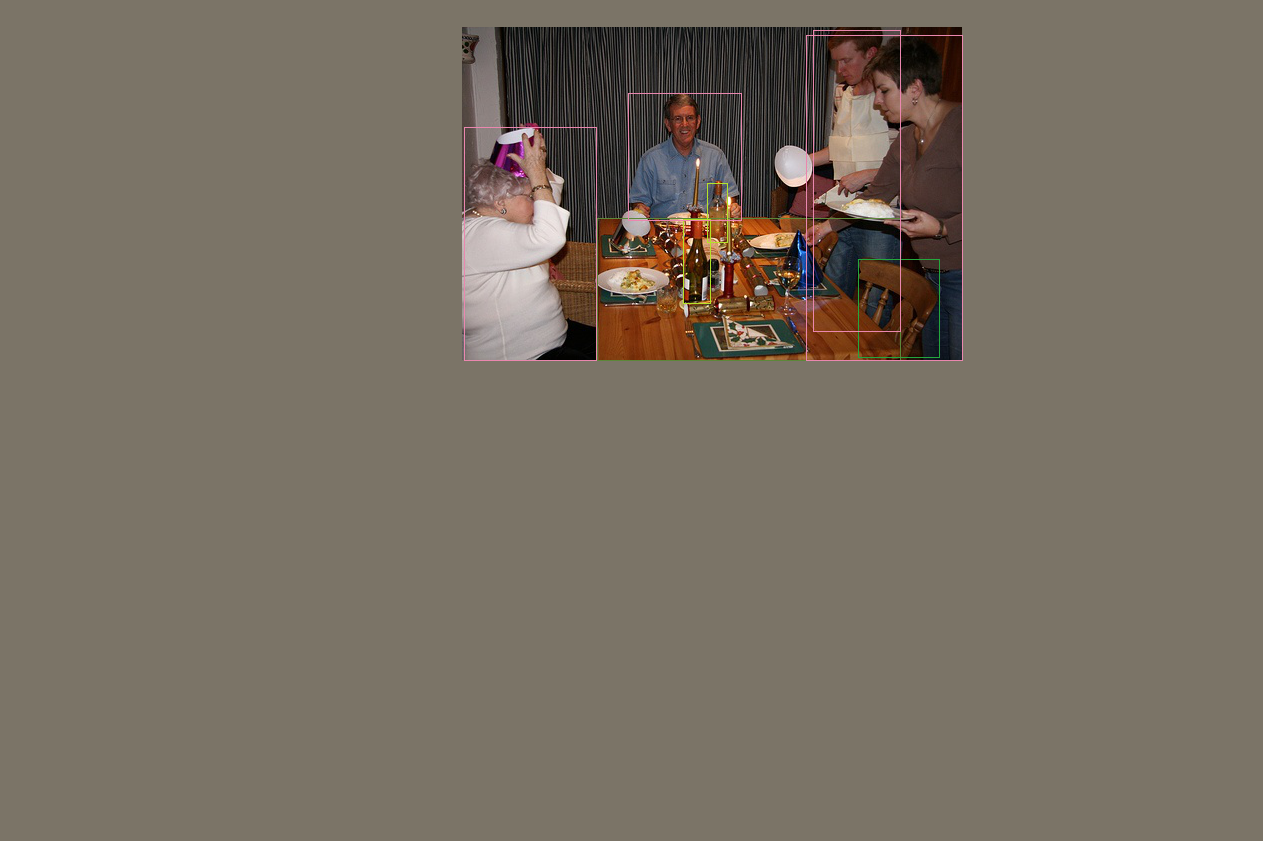

In [16]:
new_image, new_boxes = zoom_out(image, boxes)
draw_PIL_image(new_image, new_boxes, labels)

### Rotate only bouding box (optional)

In [17]:
def rotate_only_bboxes(image, boxes, angle):
    new_image = image.copy()
    new_image = F.to_tensor(new_image)
    for i in range(boxes.shape[0]):
        x_min, y_min, x_max, y_max = map(int, boxes[i,:].tolist())
        bbox = new_image[:,  y_min:y_max+1, x_min:x_max+1]
        bbox = F.to_pil_image(bbox)
        bbox = bbox.rotate(angle)
        
        new_image[:,y_min:y_max+1, x_min:x_max+1] = F.to_tensor(bbox)
    return F.to_pil_image(new_image)

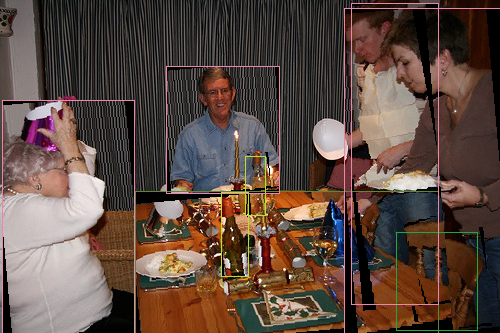

In [18]:
new_image = rotate_only_bboxes(image, boxes, 5)
draw_PIL_image(new_image, boxes, labels)

### Cutout

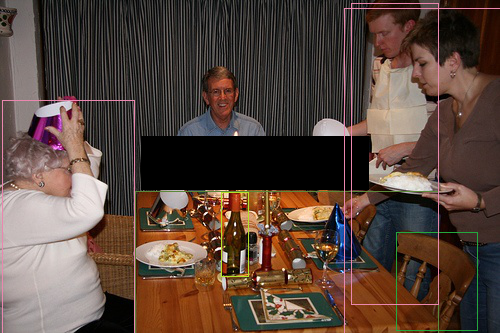

In [19]:
def cutout(image, boxes, labels, fill_val= 0, bbox_remove_thres= 0.4):
    '''
        Cutout augmentation
        image: A PIL image
        boxes: bounding boxes, a tensor of dimensions (#objects, 4)
        labels: labels of object, a tensor of dimensions (#objects)
        fill_val: Value filled in cut out
        bbox_remove_thres: Theshold to remove bbox cut by cutout
        
        Out: new image, new_boxes, new_labels
    '''
    if type(image) == PIL.Image.Image:
        image = F.to_tensor(image)
    original_h = image.size(1)
    original_w = image.size(2)
    original_channel = image.size(0)
    
    new_image = image
    new_boxes = boxes
    new_labels = labels
    
    for _ in range(50):
        #Random cutout size: [0.15, 0.5] of original dimension
        cutout_size_h = random.uniform(0.15*original_h, 0.5*original_h)
        cutout_size_w = random.uniform(0.15*original_w, 0.5*original_w)
        
        #Random position for cutout
        left = random.uniform(0, original_w - cutout_size_w)
        right = left + cutout_size_w
        top = random.uniform(0, original_h - cutout_size_h)
        bottom = top + cutout_size_h
        cutout = torch.FloatTensor([int(left), int(top), int(right), int(bottom)])
        
        #Calculate intersect between cutout and bounding boxes
        overlap_size = intersect(cutout.unsqueeze(0), boxes)
        area_boxes = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        ratio = overlap_size / area_boxes
        #If all boxes have Iou greater than bbox_remove_thres, try again
        if ratio.min().item() > bbox_remove_thres:
            continue
        
        cutout_arr = torch.full((original_channel,int(bottom) - int(top),int(right) - int(left)), fill_val)
        new_image[:, int(top):int(bottom), int(left):int(right)] = cutout_arr
        
        #Create new boxes and labels
        boolean = ratio < bbox_remove_thres
        
        new_boxes = boxes[boolean[0], :]
        
        new_labels = labels[boolean[0]]
        
        return F.to_pil_image(new_image), new_boxes, new_labels

new_image,new_boxes, new_labels = cutout(image, boxes,labels)
draw_PIL_image(new_image, new_boxes, new_labels)
